**Name:** Nauman Ali Murad 

**Reg:** 2022479

**DS211 Assingment 3**

**The datasource for this notebook is taken from kaggle and is called Nvida Share price dataset**

The models used are **Random Forest Regressor, Support Vector Machine (SVM) and Long Short-Term Memory (LSTM)**. Their predictions are mapped at the end of the notebook.

All models are sepertaly trained using same xtrain.

Want to see my work on kaggle: https://www.kaggle.com/code/naumanalimurad/nvidia-share-price-prediction

In [2]:
import numpy as np
import math
import pandas as pd
from itertools import cycle
#import yfinance as yf 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.graph_objs import Line
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

In [3]:
data = pd.read_csv('/kaggle/input/nvidia-corp-share-price-2000-2024/NVDA.csv')

# **Exploratory Data Analysis and Preprocessing** 

**In this dataset, there are seven distinct features:**
1. **Date:** This feature denotes the date and time of each trade instance.
2. **Open:** It represents the initial price of the stock when trading commenced.
3. **High:** This feature signifies the highest price reached during the specified time interval.
4. **Low:** It indicates the lowest price observed during the given time frame.
5. **Close:** This feature denotes the final price at which the stock concluded trading.
6. **Adj Close:** It represents the closing price after adjustments for all applicable splits and dividend distributions
7. **Volume:** It quantifies the total trading activity that occurred during the specified period.

Each feature provides valuable insights into the stock's performance over time, encompassing its opening, closing, highest, and lowest prices, along with the associated trading volume.

In [70]:
data # printing the dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,0.984375,0.992188,0.919271,0.975260,0.894608,30091200
1,2000-01-04,0.958333,0.960938,0.901042,0.949219,0.870721,30048000
2,2000-01-05,0.921875,0.937500,0.904948,0.917969,0.842055,18835200
3,2000-01-06,0.917969,0.917969,0.822917,0.858073,0.787112,12048000
4,2000-01-07,0.854167,0.881510,0.841146,0.872396,0.800251,7118400
...,...,...,...,...,...,...,...
6111,2024-04-18,849.700012,861.900024,824.020020,846.710022,846.710022,44726000
6112,2024-04-19,831.500000,843.239990,756.059998,762.000000,762.000000,87190500
6113,2024-04-22,781.039978,800.729980,764.000000,795.179993,795.179993,59634100
6114,2024-04-23,807.690002,827.690002,802.640015,824.229980,824.229980,43855900


In [4]:
# Rename columns
data.rename(columns={"Date":"date","Open":"open","High":"high","Low":"low","Close":"close"}, inplace= True)
data.head()

,date,open,high,low,close,Adj Close,Volume
0,2000-01-03,0.984375,0.992188,0.919271,0.975260,0.894608,30091200
1,2000-01-04,0.958333,0.960938,0.901042,0.949219,0.870721,30048000
2,2000-01-05,0.921875,0.937500,0.904948,0.917969,0.842055,18835200
3,2000-01-06,0.917969,0.917969,0.822917,0.858073,0.787112,12048000
4,2000-01-07,0.854167,0.881510,0.841146,0.872396,0.800251,7118400


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6116 entries, 0 to 6115
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       6116 non-null   object 
 1   open       6116 non-null   float64
 2   high       6116 non-null   float64
 3   low        6116 non-null   float64
 4   close      6116 non-null   float64
 5   Adj Close  6116 non-null   float64
 6   Volume     6116 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 334.6+ KB


In [6]:
print("Average Open Share Price :- ", np.mean(data['open']))
print("Average Close Share Price :- ", np.mean(data['close']))

Average Open Share Price :-  53.052266296762596
Average Close Share Price :-  53.06474054022236


In [7]:
# Summary statistics
print(" Summary statistics:")
data.describe()

 Summary statistics:


,open,high,low,close,Adj Close,Volume
count,6116.000000,6116.000000,6116.000000,6116.000000,6116.000000,6.116000e+03
mean,53.052266,54.017201,52.031700,53.064741,52.794253,6.221933e+07
std,121.267334,123.423982,118.835114,121.183234,121.214864,4.316714e+07
min,0.608333,0.656667,0.600000,0.614167,0.563377,4.564400e+06
25%,2.959688,3.027500,2.875000,2.950391,2.707880,3.615840e+07
50%,4.683750,4.747500,4.608750,4.682500,4.389289,5.206235e+07
75%,42.101873,42.645625,41.500000,42.102499,41.741090,7.465490e+07
max,958.510010,974.000000,935.099976,950.020020,950.020020,9.230856e+08


In [8]:
# Check for duplicates
print(" Number of duplicates:", data.duplicated().sum())

 Number of duplicates: 0


In [24]:
# Checking Data type of each column
print("Date column data type: ", type(data['date'][0]))
print("Open column data type: ", type(data['open'][0]))
print("Close column data type: ", type(data['close'][0]))
print("High column data type: ", type(data['high'][0]))
print("Low column data type: ", type(data['low'][0]))

Date column data type:  <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>


In [22]:
# convert date field from string to Date format and make it index
data['date'] = pd.to_datetime(data.date)
data.head()

,date,open,high,low,close,Adj Close,Volume
0,2000-01-03,0.984375,0.992188,0.919271,0.975260,0.894608,30091200
1,2000-01-04,0.958333,0.960938,0.901042,0.949219,0.870721,30048000
2,2000-01-05,0.921875,0.937500,0.904948,0.917969,0.842055,18835200
3,2000-01-06,0.917969,0.917969,0.822917,0.858073,0.787112,12048000
4,2000-01-07,0.854167,0.881510,0.841146,0.872396,0.800251,7118400


In [23]:
data.sort_values(by='date', inplace=True)
data.head() #storing dataset by date formate

,date,open,high,low,close,Adj Close,Volume
0,2000-01-03,0.984375,0.992188,0.919271,0.975260,0.894608,30091200
1,2000-01-04,0.958333,0.960938,0.901042,0.949219,0.870721,30048000
2,2000-01-05,0.921875,0.937500,0.904948,0.917969,0.842055,18835200
3,2000-01-06,0.917969,0.917969,0.822917,0.858073,0.787112,12048000
4,2000-01-07,0.854167,0.881510,0.841146,0.872396,0.800251,7118400


In [25]:
data.shape

(6116, 7)

# **Visualization**
This visualization is also a part of the extensive EDA

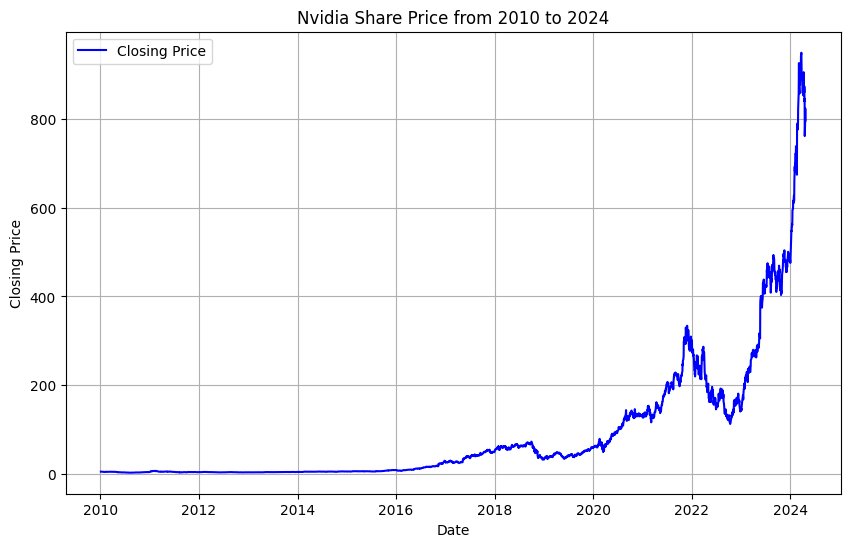

In [91]:
# Assuming 'date' column contains the date information
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Assuming 'close' column contains the closing price information
data_2010_to_2024 = data['2010':'2024']

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(data_2010_to_2024.index, data_2010_to_2024['close'], label='Closing Price', color='blue')
plt.title('Nvidia Share Price from 2010 to 2024')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
monthvise= data.groupby(data['date'].dt.strftime('%B'))[['open','close']].mean().sort_values(by='close')
monthvise.head()

,open,close
date,,
May,38.202963,38.301326
June,44.039314,44.105209
July,45.498201,45.532563
October,47.222969,47.255780
September,48.433340,48.304540


In [28]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['open'],
    name='Share Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['close'],
    name='Share Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Share actual, open and close price')
fig.show()

In [29]:
monthvise_high = data.groupby(data['date'].dt.strftime('%B'))['low'].max()

In [30]:
monthvise_low = data.groupby(data['date'].dt.strftime('%B'))['low'].min()

In [31]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Share high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Share low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low Share price')
fig.show()

In [32]:
# Filter data for the specified time range
data_filtered = data[(data['date'] >= pd.Timestamp('2016-01-01')) & (data['date'] <= pd.Timestamp('2024-12-31'))]

# Plotting the share price from 2016 till 2024
fig = make_subplots(rows=4, cols=1, subplot_titles=('Open', 'High', 'Low', 'Close'))

fig.add_trace(
    go.Line(x=data_filtered['date'], y=data_filtered['open']),
    row=1, col=1
)

fig.add_trace(
    go.Line(x=data_filtered['date'], y=data_filtered['high']),
    row=2, col=1
)

fig.add_trace(
    go.Line(x=data_filtered['date'], y=data_filtered['low']),
    row=3, col=1
)

fig.add_trace(
    go.Line(x=data_filtered['date'], y=data_filtered['close']),
    row=4, col=1
)

fig.update_layout(height=1400, width=1000, title_text="Open, High, Low, Close Line Plots (2012-2024)")
fig.show()


/opt/conda/lib/python3.10/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/opt/conda/lib/python3.10/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/opt/conda/lib/python3.10/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/opt/conda/lib/python3.10/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprec

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version

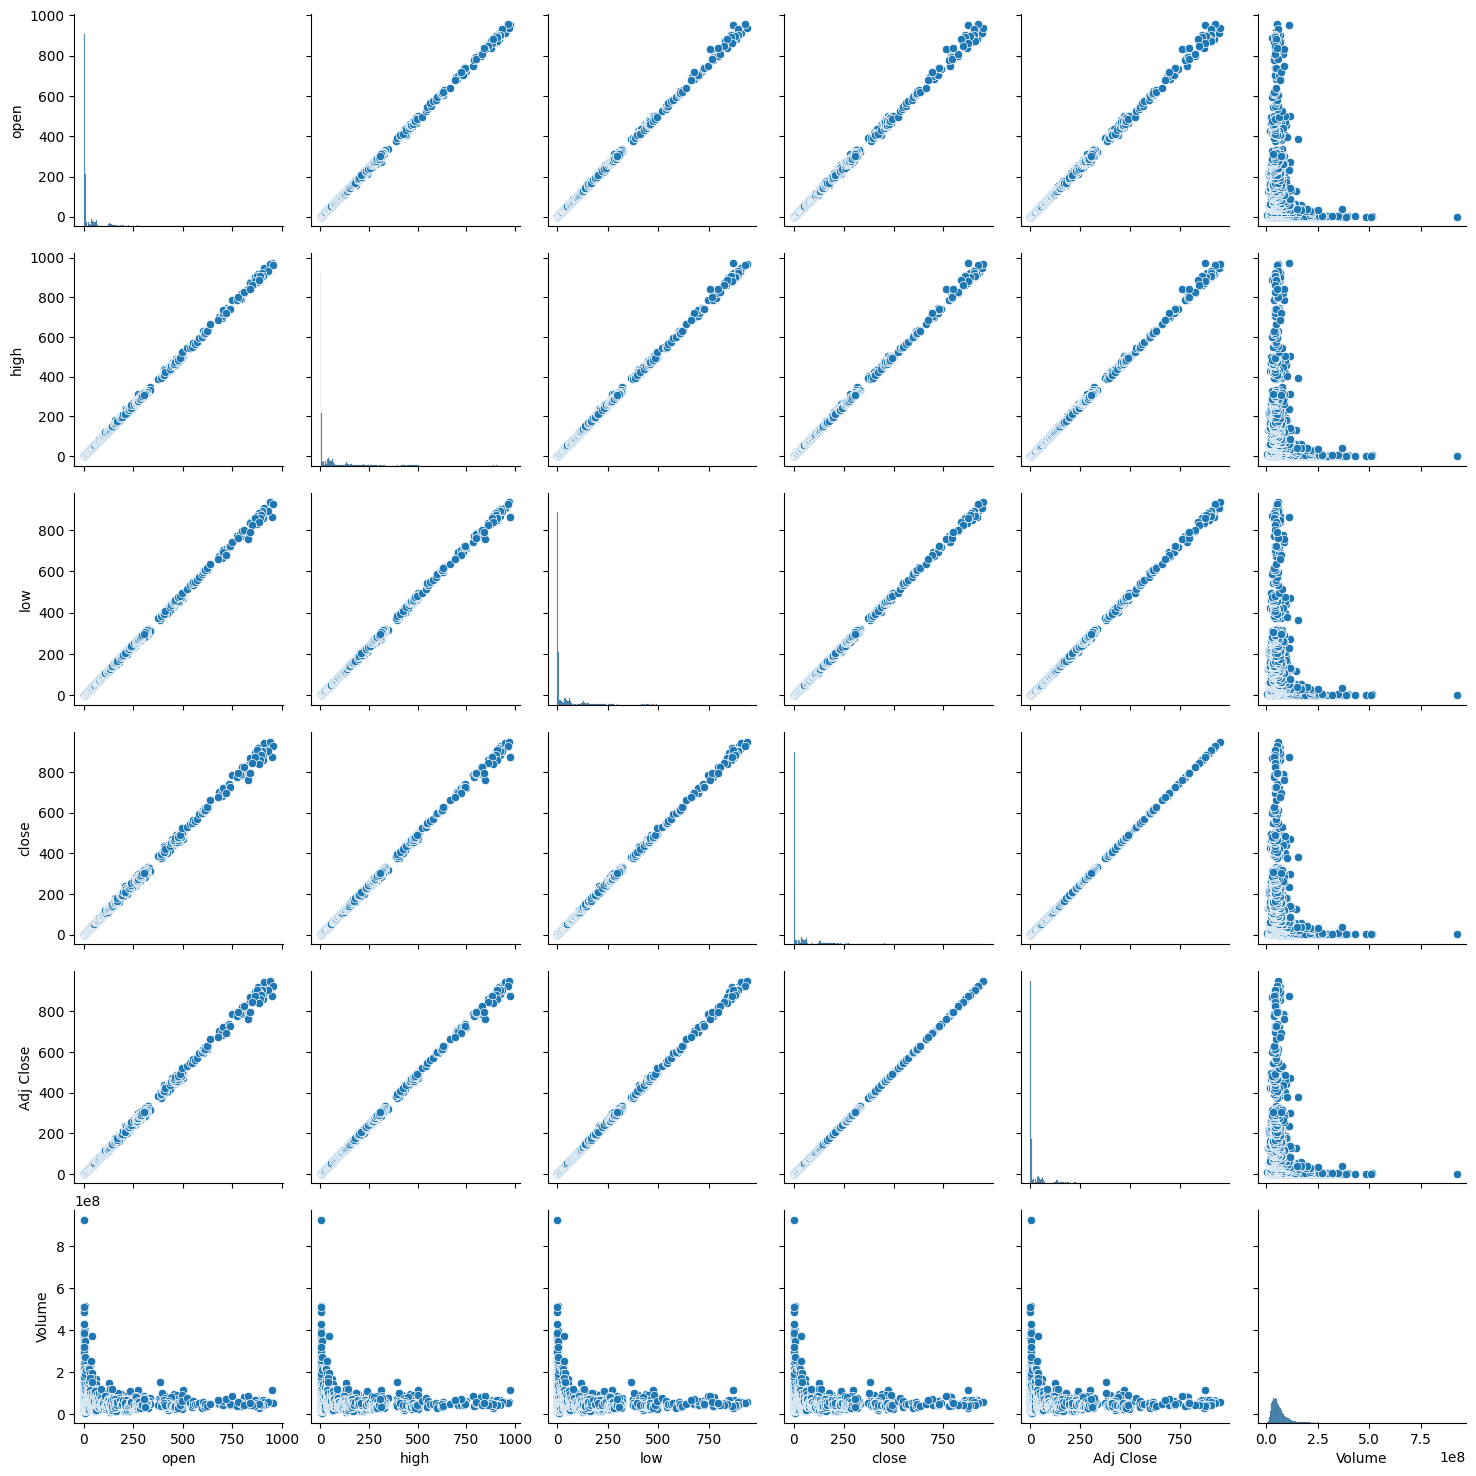

In [33]:
sns.pairplot(data) # plot pairwise relationships between variables within a data set.

In [35]:
names = cycle(['Share Open Price','Share Close Price','Share High Price','Share Low Price'])

fig = px.line(data, x=data.date, y=[data['open'], data['close'], 
                                          data['high'], data['low']],
             labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Share analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

<Figure size 1000x600 with 0 Axes>

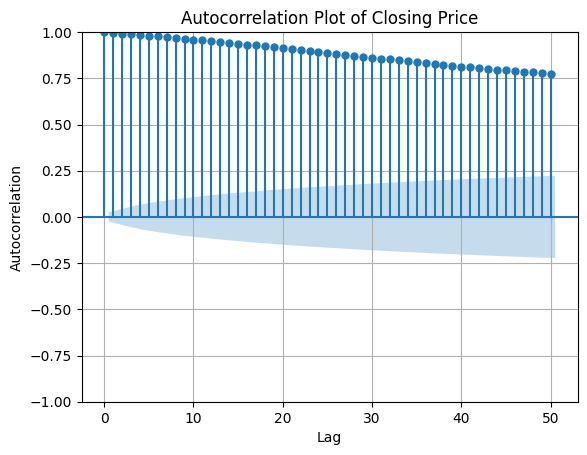

<Figure size 1000x600 with 0 Axes>

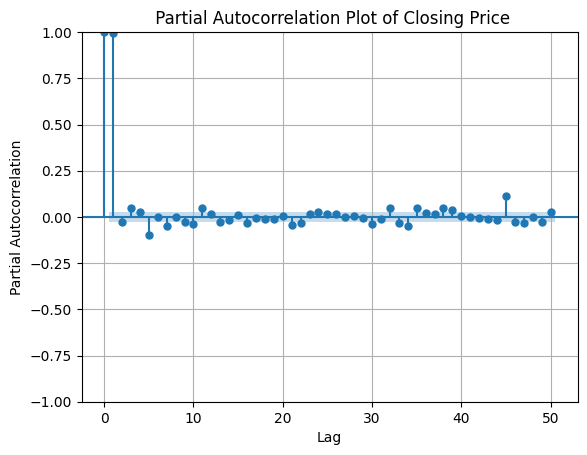

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelation plot`
plt.figure(figsize=(10, 6))
plot_acf(data['close'], lags=50)
plt.title('Autocorrelation Plot of Closing Price')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()
print("\n")
print("\n")

#  Partial Autocorrelation plot
plt.figure(figsize=(10, 6))
plot_pacf(data['close'], lags=50)
plt.title(' Partial Autocorrelation Plot of Closing Price')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

In [46]:
closedf = data[['close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (6116, 1)


In [47]:
print("Starting date: ", data.iloc[0, 0])
print("Ending date: ", data.iloc[-1, 0])
print("Duration: ", data.iloc[-1, 0] - data.iloc[0, 0])

Starting date:  2000-01-03 00:00:00
Ending date:  2024-04-24 00:00:00
Duration:  8878 days 00:00:00


# **We need to predict the closing price for the share, since we are only interested in the closing price we will create a seperate dataframe with close price that will help is in making the necessary requirements for the model**

In [48]:
closedf = data[['date','close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (6116, 2)


In [49]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='Stock close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

**Data Normalizatiom**

In [50]:
close_stock = closedf.copy()
del closedf['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(6116, 1)


In [51]:
training_size=int(len(closedf)*0.65)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (3975, 1)
test_data:  (2141, 1)


In [52]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [53]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (3959, 15)
y_train:  (3959,)
X_test:  (2125, 15)
y_test (2125,)


# **Implemeting the Models**

# **Random Forest Regressor - RF**

In [54]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

**Predictions**

In [56]:
train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (3959, 1)
Test data prediction: (2125, 1)


In [57]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [58]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  0.05126084440467081
Train data MSE:  0.0026276741690798707
Test data MAE:  0.033993798211669604
-------------------------------------------------------------------------------------
Test data RMSE:  217.53884725601236
Test data MSE:  47323.15006547467
Test data MAE:  136.23108582568003


In [60]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (6116, 1)
Test predicted data:  (6116, 1)


In [62]:
rfdf=closedf.tolist()
rfdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
rfdf=scaler.inverse_transform(rfdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(rfdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

## Findings and Insights from Random Forest Regressor Results

* **Training Performance:**
    * The Root Mean Squared Error (RMSE) on the training data is 0.051, which is a relatively low value. This indicates a good fit between the model and the training data. 
    * The Mean Squared Error (MSE) on the training data is even lower at 0.0026, further suggesting that the model is accurately capturing the patterns in the training data.

* **Testing Performance:**
    * There seems to be a significant discrepancy between the training and testing performance. While the training metrics show a good fit, the testing metrics indicate a  large generalization error. 
        * The test data RMSE is much higher at 217.54, suggesting that the model is not generalizing well to unseen data. 
        * The test data MSE is also quite high at 47323.15, reinforcing the issue of poor generalization.
        * The test data MAE of 136.23  further highlights the model's struggle with predicting accurate values on unseen data.

# Support Vector Machine

In [63]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel= 'rbf', C= 1e2, gamma= 0.1)
svr_rbf.fit(X_train, y_train)

SVR(C=100.0, gamma=0.1)

In [64]:
# Lets Do the prediction 

train_predict=svr_rbf.predict(X_train)
test_predict=svr_rbf.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)


Train data prediction: (3959, 1)
Test data prediction: (2125, 1)


In [65]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [66]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  2.3923016567912216
Train data MSE:  5.723107217086024
Test data MAE:  2.0501973262187416
-------------------------------------------------------------------------------------
Test data RMSE:  220.3040819080668
Test data MSE:  48533.8885053562
Test data MAE:  140.50317883176473


# LSTM

In [67]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (3959, 15, 1)
X_test:  (2125, 15, 1)


In [75]:
tf.keras.backend.clear_session()

model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(time_step, 1)))  # Add Dropout after LSTM
model.add(LSTM(32, return_sequences=True))  # Add Dropout after LSTM
model.add(LSTM(32, dropout=0.2))  # Add Dropout after LSTM
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [76]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=5,verbose=1)

Epoch 1/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 5.5721e-06 - val_loss: 0.0067
Epoch 2/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 4.3427e-07 - val_loss: 0.0127
Epoch 3/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 4.3550e-07 - val_loss: 0.0140
Epoch 4/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 4.1157e-07 - val_loss: 0.0224
Epoch 5/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 4.0580e-07 - val_loss: 0.0199
Epoch 6/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 2.5319e-07 - val_loss: 0.0189
Epoch 7/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 2.7916e-07 - val_loss: 0.0189
Epoch 8/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 2.7605e-07 - val_loss: 0.0185
Epoch 9/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 3.3418e-07 - val_loss: 0.0195
Epoch 10/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 2.0320e-07 - val_loss: 0.0163
Epoch 11/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 2.4767e-07 - val

In [77]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


((3959, 1), (2125, 1))

In [78]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [79]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  0.285103892803431
Train data MSE:  0.08128422969167028
Test data MAE:  0.2478781270334803
-------------------------------------------------------------------------------------
Test data RMSE:  110.68454841040887
Test data MSE:  12251.069256816143
Test data MAE:  41.32269241763576


In [85]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (3959, 15, 1)
X_test:  (2125, 15, 1)


In [87]:
from tensorflow.keras.layers import LSTM, GRU
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [88]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=5,verbose=1)

Epoch 1/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 1.3838e-05 - val_loss: 0.0024
Epoch 2/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 3.6149e-07 - val_loss: 0.0029
Epoch 3/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 2.9398e-07 - val_loss: 0.0046
Epoch 4/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 3.9877e-07 - val_loss: 0.0058
Epoch 5/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 2.8665e-07 - val_loss: 0.0073
Epoch 6/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 2.4401e-07 - val_loss: 0.0194
Epoch 7/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 2.8731e-07 - val_loss: 0.0107
Epoch 8/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 1.6266e-07 - val_loss: 0.0099
Epoch 9/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 1.6910e-07 - val_loss: 0.0143
Epoch 10/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 2.1574e-07 - val_loss: 0.0119
Epoch 11/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 1.8512e-07 - val_loss: 0.0151
Epoch 12

In [89]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


((3959, 1), (2125, 1))

In [90]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  3.870602755850407
Train data MSE:  14.981565693596766
Test data MAE:  3.5060626931688392
-------------------------------------------------------------------------------------
Test data RMSE:  223.6203247985035
Test data MSE:  50006.0496629882
Test data MAE:  145.67980511971388


## Report on Stock Price Prediction Findings and Insights

This report analyzes the performance of three machine learning models for predicting stock prices: Random Forest Regressor, Support Vector Machine (SVM), and Long Short-Term Memory (LSTM). The report includes findings on the training and testing performance of each model.

**Data and Preprocessing**

* The data used for this analysis is a time series of closing stock prices.
* The data was scaled before feeding it to the machine learning models.

**Random Forest Regressor**

* The Random Forest Regressor achieved a low Root Mean Squared Error (RMSE) of 0.051 on the training data, indicating a good fit between the model and the training data.
* The Mean Squared Error (MSE) on the training data was also low at 0.0026, further suggesting that the model is accurately capturing the patterns in the training data.
* However, there was a significant discrepancy between the training and testing performance. The test data RMSE was much higher at 217.54, suggesting that the model does not generalize well to unseen data.
* The test data MAE of 136.23 further highlights the model's struggle with predicting accurate values on unseen data.

**Support Vector Machine (SVM)**

* The SVM model exhibited a lower training performance compared to the Random Forest Regressor, with a training data RMSE of 2.39.
* The test data performance of the SVM was also poor, with a test data RMSE of 220.30.
* Overall, the SVM model did not perform well on this dataset.

**Long Short-Term Memory (LSTM)**

* The LSTM model achieved a better training performance than the Random Forest Regressor and SVM, with a training data RMSE of 0.28.
* However, the test data performance of the LSTM model was still not ideal, with a test data RMSE of 110.68.
* This suggests that even the LSTM model, which is specifically designed for time series forecasting, has difficulty generalizing to unseen data.

**Findings and Insights**

* All three machine learning models struggled to generalize well to unseen test data. This could be due to several factors, such as the inherent difficulty of financial time series forecasting and the limitations of the chosen models or hyperparameters.
* The Random Forest Regressor achieved the best training performance but failed to generalize well. This suggests that the model may be overfitting the training data.
* The LSTM model achieved a better balance between training and testing performance but still exhibited significant generalization errors. This suggests that even LSTM models may not be sufficient for accurate stock price prediction on this dataset.

